<a href="https://colab.research.google.com/github/blackBagel/Sarcasm-Detection-Learn/blob/main/sarcasm_detection_simple_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
! pip install eli5

     |████████████████████████████████| 112kB 2.8MB/s 


In [5]:
from __future__ import print_function
import pandas as pd
import numpy as np
import os
from google.colab import drive
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import spacy
import re
from sklearn import preprocessing, decomposition, model_selection, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
import eli5
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


# Data preparation

In [6]:
DRIVE_PATH = '/gdrive/My Drive/Reddit sarcasm'
drive.mount('/gdrive')
os.chdir(DRIVE_PATH)

Mounted at /gdrive


In [7]:
DATA_COLUMNS = [
    'labels',
    'comments',
    'authors',
    'subreddit',
    'score',
    'ups',
    'downs',
    'date',
    'created_utc',
    'parent_comment'
]

full_comments_df = pd.read_csv("train-balanced-sarc.csv", delimiter='\t', names=DATA_COLUMNS)

## Methodology

First, let's see the data distributions

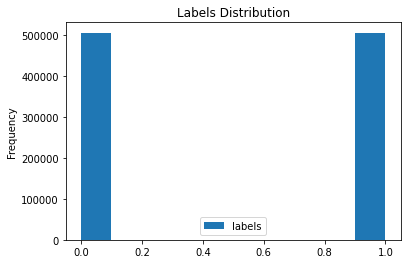

In [8]:
full_comments_df.plot(kind='hist', y='labels', title = 'Labels Distribution')

The data is balanced with regard to the labels. Therefore, I'll use the accuracy metric to evaluate all future models.

I prefer to evaluate all the models based primarily on accuracy. The data is well balanced and there is no actual buisiness problem i'm solving here, so there's not much of a need to specifically avoid either FPs or FNs.

I will however keep the precision and recall scores of all models for future reference

#### Train-Validation-Test Split 

The dataset is quite relatively large with about 1 million comments. For that reason, it is quite reasonable to use only 4% of the data as test and validation sets, since they'll still be 20k each.

That way, we'll have lots of data to train on.

In [49]:
comments_df_without_labels = full_comments_df.iloc[:, 1:]

# We use the same train-test split to test all of the next models
df_train, df_test, labels_train, labels_test = train_test_split(comments_df_without_labels,
                                                                full_comments_df['labels'],
                                                                random_state=1,
                                                                test_size=0.04,
                                                                shuffle=True)

df_val, df_test, labels_val, labels_test = train_test_split(df_test,
                                                            labels_test,
                                                            random_state=5,
                                                            test_size=0.5,
                                                            shuffle=True)

Let's make sure the validation and test set have similar distributions

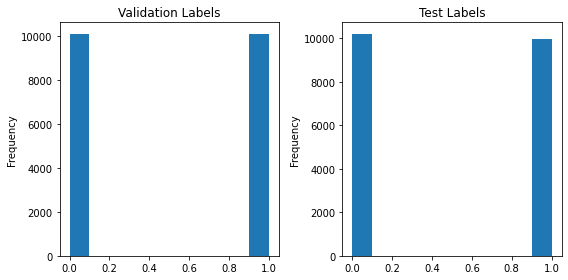

In [26]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))

labels_val.plot.hist(ax = axes[0], title='Validation Labels')
labels_test.plot.hist(ax = axes[1], title='Test Labels')
fig.tight_layout()

##### Null handling

In [52]:
print("Nulls in training set:")
df_train.isnull().sum()

Nulls in training set:


comments          51
authors            0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

Since I don't want to divide and reassemble the data and the labels each time i apply a function to both, i'll simply create a function that applies row based functions to them and handles the dividing and reassembling for me

In [53]:
def handle_row_dropping_functions(df, labels, row_dropping_funcs={}):
  """
  Applies data munging functions that may drop rows in the dataset
  This function makes sure the corresponding labels of each dropped row is deleted as well

  Parameters
  ----------
  df : pandas DataFrame
      The dataset to apply the functions on
  labels : pandas Series
      The corresponding labels of the dataset
  row_dropping_funcs : Dict
      A dictionary containing functions as keys
      and any parameters necessary for them (except the df!) as values

  Returns
  -------
  new_df
      The recieved DF after being handled the fucntions
  new_labels:
      The labels for the df, without the dropped rows
  """

  # Combine data and labels based on their index
  new_df = df.copy()
  new_labels = labels.copy()
  new_df['labels'] = new_labels
  
  # Apply row dropping functions
  for row_dropping_func, func_params in row_dropping_funcs.items():
    func_params['df'] = new_df
    new_df = row_dropping_func(**func_params)
  
  # Return the updated datasets as they were before
  new_labels = new_df['labels']
  new_df = new_df.drop(columns = ['labels'])

  return new_df, new_labels

In [54]:
def handle_nulls(**kwargs):
  """
  Returns the df without rows where some columns are null
  Right now could have been done without a function,
  but useful for encapsulating more complex null handling situations in the future

  Parameters
  ----------
  df : pandas DataFrame
      The dataset to drop NaNs from
  unfixable_columns : list
      The columns that need to be dropped if empty (default is an empty list)

  Returns
  -------
  new_df
      The recieved DF but with rows without null columns
  """

  new_df = kwargs['df'].copy()
  new_df = new_df.dropna(subset = kwargs['unfixable_columns'])
  return new_df

In [55]:
# Columns to be dropped if null
DROPPABLE_COLUMNS = ['comments']

row_dropping_funcs = {
    handle_nulls: { 'unfixable_columns': DROPPABLE_COLUMNS }
    }

df_train, labels_train = handle_row_dropping_functions(df_train, labels_train, row_dropping_funcs = row_dropping_funcs)

df_train.isnull().sum()

comments          0
authors           0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

# Research Process

## We begin our research by trying out a basic logistic regression model with different feature sets



### First, a relatively primitive count vectorizer of the texts

In [ ]:
ctv = CountVectorizer(ngram_range=(1, 2), min_df=2)
lr_ctv_clf = LogisticRegression(solver='saga', C=1, n_jobs=4, verbose=0)
ctv_logit_pipeline = Pipeline([('counter', ctv), 
                                 ('logitRegressor', lr_ctv_clf)])

In [ ]:
%%time
ctv_logit_pipeline.fit(df_train, labels_train)

In [ ]:
predictions = ctv_logit_pipeline.predict_proba(df_test)
print ("logloss: %0.3f " % log_loss(labels_test, predictions))
print ("accuracy: %0.3f " % ctv_logit_pipeline.score(df_test, labels_test))

### We also test a basic tf-idf vector

In [ ]:
# We'll first try to create a simple baseline model
# Our baseline model will be a logistic regression model, which we'll train on the unigram tf_idf vectors of the original comments text 
tfv = TfidfVectorizer()

tfidf_logit_pipeline = Pipeline([('tf_idf', tfv), 
                                 ('logitRegressor', lr_tfv_clf)])
lr_tfv_clf = LogisticRegression(solver='saga')

In [ ]:
%%time
tfidf_logit_pipeline.fit(df_train, labels_train)

In [ ]:
predictions = lr_tfv_clf.predict_proba(df_test)

print ("logloss: %0.3f " % log_loss(labels_test, predictions))
print ("accuracy: %0.3f " % lr_tfv_clf.score(df_test, labels_test))

### We try a more sophisticated tf-idf vector

In [ ]:
# Now let's try to run the same model, but on a more sophisticated tf-idf 
# This vectorizor is trained on both unigrams and bigrams, and only considers words that were used at least twice
tfv = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
lr_tfv_clf = LogisticRegression(solver='saga', C=1, n_jobs=4, verbose=0)
tfidf_logit_pipeline = Pipeline([('tf_idf', tfv), 
                                 ('logitRegressor', lr_tfv_clf)])

In [ ]:
%%time
tfidf_logit_pipeline.fit(df_train, labels_train)

In [ ]:
# This model gave us the best performance for this part of the research
predictions = tfidf_logit_pipeline.predict_proba(df_test)
print ("logloss: %0.3f " % log_loss(labels_test, predictions))
print ("accuracy: %0.3f " % tfidf_logit_pipeline.score(df_test, labels_test))

In [ ]:
# Because it was te best model we tried to understand better what affected his performance
eli5.show_weights(estimator=tfidf_logit_pipeline.named_steps['logitRegressor'],
                  vec=tfidf_logit_pipeline.named_steps['tf_idf'])

### We theorize that certain pos tags could be strong indicators of sarcasm

In [ ]:
# !python -m spacy download en_core_web_lg
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner', 'textcat'])

In [ ]:
comments_pos_tags = []
print('Parsing pos tags...')
parsed_comments = [nlp(comment) for comment in tqdm(comments)]
for parsed_comment in parsed_comments:
  comment_pos_tags = []
  for word in parsed_comment:
    comment_pos_tags.append(word.tag_)
  comments_pos_tags.append(' '.join(comment_pos_tags))

In [ ]:
# Now let's try to run the same model, but on a more sophisticated tf-idf 
tfv = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
lr_tfv_clf = LogisticRegression(solver='saga', C=1, n_jobs=4, verbose=0)
tfidf_logit_pipeline = Pipeline([('tf_idf', tfv), 
                                 ('logitRegressor', lr_tfv_clf)])

# This vectorizor is trained on both unigrams and bigrams, and only considers words that were used at least twice
df_train, df_test, labels_train, labels_test = train_test_split(comments_pos_tags,
                                                    full_labels,
                                                    random_state=1,
                                                    test_size=0.2,
                                                    shuffle=True)

In [ ]:
%%time
tfidf_logit_pipeline.fit(df_train, labels_train)

In [ ]:
predictions = tfidf_logit_pipeline.predict_proba(df_test)
print ("logloss: %0.3f " % log_loss(labels_test, predictions))
print ("accuracy: %0.3f " % tfidf_logit_pipeline.score(df_test, labels_test))

# As it seems, using the plain pos tags as replacements of the words, loses some vital information for the classification
eli5.show_weights(estimator=tfidf_logit_pipeline.named_steps['logitRegressor'],
                  vec=tfidf_logit_pipeline.named_steps['tf_idf'])